In [ ]:
'''
Reproduce old scatter plots that were used in maiasaurus-v5.ipynb.  The original program should be located in the folder
old-stuff.
'''

In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import LMC
import archinfo
import imp
import astropy.stats
import scipy.signal as sig
import scipy.optimize as op
import dcor
import random
import math

from scipy import stats
from timeit import default_timer

from sklearn.cluster   import KMeans
from sklearn.cluster   import SpectralClustering
from sklearn.neighbors import DistanceMetric

from KDEpy import FFTKDE

# define a few constants
pi = np.pi

MSME = 332948.6                            # (M_sun/M_earth)

RNRE = 3.8647      # (Rnep/Rearth)
RJRE = 10.973      # (Rjup/Rearth)
RSRE = 109.2       # (Rsun/Rearth)

RSRN = RSRE/RNRE   # (Rsun/Rnep)
RSRJ = RSRE/RJRE   # (Rsun/Rjup)

BIGG = 6.67e-11    # Newton's constant [SI units]

RSUN = 6.957e8     # solar radius [m]
MSUN = 1.988e30    # Solar mass [kg]

GSUN = BIGG / RSUN**3 * MSUN * (24*3600)**2    # Newton's constant [R_sun^3 * M_sun^-1 * days^-2]

# define a few colors
robinseggblue = '#bfe2ff'
royalpurple = '#9e00a3'
lavender = '#cc98d9'

# set path
MAINPATH = 'C:/Users/djhoo/Documents/maiasaurus-master/'

# Read in CKS data

In [2]:
# READ IN CKS DATABASE
# documentation of csv file found at http://www.astro.caltech.edu/~howard/cks/column-definitions.txt

cks_file = MAINPATH + 'catalogues/clean_kepler_catalogue.csv'

cks_data = []
with open(cks_file) as infile:
    reader = csv.reader(infile)
    
    for row in reader:
        cks_data.append(row)        
        
KEYS = cks_data[0]
VALUES = cks_data[1:]

def getkey(keyname,keys=KEYS,values=VALUES):
    '''
    keyname = (string) of column definition, see CKS documentation
    '''
    kid = keys.index(keyname)
    
    dummy = []
    for row in values:
        dummy.append(row[kid])
    
    return dummy

In [3]:
# PULL RELEVANT QUANTITIES FROM CKS
d = {}

d['starname']    = getkey('id_starname')             # star id - 'K00082'
d['koi']         = getkey('id_koicand')
d['kic']         = getkey('id_kic')                  # Kepler Input Catalogue ID
d['disposition'] = getkey('koi_disposition')         # status - 'CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE', etc.
d['falsepos']    = getkey('cks_fp')                  # CKS false positive designation - 'False' or 'True'
d['snr']         = getkey('koi_model_snr')           # transit signal-to-noise
d['npl']         = getkey('koi_count')               # number of planets in system

d['period']      = getkey('koi_period')              # period (days)
d['period_err1'] = getkey('koi_period_err1')
d['period_err2'] = getkey('koi_period_err2')

d['rprs']      = getkey('koi_ror')                   # planet-to-star radius ratio
d['rprs_err1'] = getkey('koi_ror_err1')
d['rprs_err2'] = getkey('koi_ror_err2')

d['impact']      = getkey('koi_impact')              # impact parameter
d['impact_err1'] = getkey('koi_impact_err1')
d['impact_err2'] = getkey('koi_impact_err2')

d['koi_duration']      = getkey('koi_duration')      # transit duration (hours)
d['koi_duration_err1'] = getkey('koi_duration_err1')
d['koi_duration_err2'] = getkey('koi_duration_err2')

d['rp']      = getkey('iso_prad')                    # CKS+isochrone constrained planet radius (earth radius)
d['rp_err1'] = getkey('iso_prad_err1')
d['rp_err2'] = getkey('iso_prad_err2')

d['sma']      = getkey('iso_sma')                    # CKS+isochrone constrained semi-major axis (AU)
d['sma_err1'] = getkey('iso_sma_err1')
d['sma_err2'] = getkey('iso_sma_err2')

d['rstar']      = getkey('iso_srad')                 # CKS+isochrone constrained stellar radius (solar radius)
d['rstar_err1'] = getkey('iso_srad_err1')
d['rstar_err2'] = getkey('iso_srad_err2')

d['mstar']      = getkey('iso_smass')                # CKS+isochrone constrained stellar mas (solar mass)
d['mstar_err1'] = getkey('iso_smass_err1')
d['mstar_err2'] = getkey('iso_smass_err2')

d0 = d.copy()

In [4]:
# QUICKLY CLEAN DATA

d = d0.copy()

KEY0 = 'starname'

def check_lengths(d, key0=KEY0):
    '''
    checks that all data arrays are the same length
    '''
    keys = d.keys()    
    L0   = len(d[key0])
        
    for k in keys:
        if len(d[k]) != L0: raise ValueError('inconsistent array length for array "%s"' %k)
            
    return None


def convert_to_arrays(d):
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        dnew[k] = np.asarray(d[k])
        
    return dnew

    
    
def remove_missing_data(d, key0=KEY0):
    '''
    removes empty data cells
    '''
    keys = d.keys()
    L0   = len(d[key0])
    dnew = {}
    
    empty = np.zeros(L0)
    
    for k in keys:
        empty += d[k] == ''
    
    empty = empty > 0.0

    for k in keys:
        dnew[k] = d[k][~empty]

    check_lengths(dnew)
    
    return dnew


# CLEAN DATA
d = convert_to_arrays(d)
print('total number of queried objects =', len(d[KEY0]))

d = remove_missing_data(d)
print('after removing missing data, number of objects =', len(d[KEY0]))

check_lengths(d)

total number of queried objects = 864
after removing missing data, number of objects = 864


In [5]:
# CONVERT STRINGS TO FLOATS
def is_number(s):
    '''
    checks if input string s is a number
    '''
    try:
        float(s)
        return True
    except ValueError:
        return False
    
def convert_floats(d):
    '''
    converts numerical arrays from strings to floats
    '''
    keys = d.keys()
    dnew = {}
    
    for k in keys:
        if is_number(d[k][0]):
            dnew[k] = np.asarray(d[k],dtype='float')
        else:
            dnew[k] = np.asarray(d[k])
    
    return dnew


# CONVERT STRINGS TO FLOATS (where applicable)
d = convert_floats(d)

# Read in masses from Andrew

In [6]:
d['mp'] = np.load(MAINPATH + 'catalogues/cks_pred_masses_oct9.npy')[0]

# Calculate compexity metrics for each system

In [7]:
class System:
    def __init__(self, sysid=None):
        
        self.sysid = sysid

In [8]:
uniquesys = np.unique(d['starname'])
systems   = []

for us in uniquesys:
    # initialize System() object
    s = System()
    
    # pull stellar data
    # these values are repeated only once 
    s.sysid   = us
    s.Mstar   = d['mstar'][d['starname']==us][0]
    s.Rstar   = d['rstar'][d['starname']==us][0]
    
    # pull planetary data
    # these values are lists corresponding to all the planets
    s.rprs    = d['rprs'][d['starname']==us]
    s.masses  = d['mp'][d['starname']==us]
    s.periods = d['period'][d['starname']==us]

    # pull transit durations and errors, convert hrs to days
    s.dur     = d['koi_duration'][d['starname']==s.sysid]/24
    s.dur_err = 0.5*((d['koi_duration_err1'][d['starname']==s.sysid]) -
                     (d['koi_duration_err2'][d['starname']==s.sysid]))/24
    
    """
    # Adding in Jupiter, Saturn, and Uranus
    
    s.Mstar = np.append(s.Mstar, 9.542e-4) #Jupiter
    s.Mstar = np.append(s.Mstar, 2.857e-4) #Saturn
    s.Mstar = np.append(s.Mstar, 4.365e-5) #Uranus
    
    s.Rstar = np.append(s.Rstar, 0.103) #Jupiter
    s.Rstar = np.append(s.Rstar, 0.087) #Saturn
    s.Rstar = np.append(s.Rstar, 0.037) #Uranus
    
    s.rprs = np.append(s.rprs, [0.025480, 0.021832, 0.036845, 0.033714]) #Io, Europa, Ganymede, Callisto
    s.rprs = np.append(s.rprs, [0.003289, 0.004183, 0.008812, 0.009315, 0.012673, 0.042721, 0.012187]) #Mimas, Enceladus, Tethys, Dione, Rhea, Titan, Iapetus
    s.rprs = np.append(s.rprs, [0.030846, 0.029790, 0.022650, 0.022876, 0.009226]) #Titania, Oberon, Ariel, Umbriel, Miranda
    
    s.masses = np.append(s.masses, [0.015, 0.008, 0.025, 0.018]) #Io, Europa, Ganymede, Callisto
    s.masses = np.append(s.masses, [6.3e-6, 1.8e-5, 1.03e-4, 1.834e-4, 3.9e-4, 0.0225, 3.02e-4]) #Mimas, Enceladus, Tethys, Dione, Rhea, Titan, Iapetus
    s.masses = np.append(s.masses, [5.69e-4, 5.15e-4, 2.09e-4, 2.13e-4, 1.07e-5]) #Titania, Oberon, Ariel, Umbriel, Miranda
    
    s.periods = np.append(s.periods, [1.769137786, 3.551181, 7.15455296, 16.6890184]) #Io, Europa, Ganymede, Callisto
    s.periods = np.append(s.periods, [0.942, 1.370218, 1.887802, 2.736915, 4.518212, 15.945, 79.3215]) #Mimas, Enceladus, Tethys, Dione, Rhea, Titan, Iapetus
    s.periods = np.append(s.periods, [8.706234, 13.463234, 2.520, 4.144, 1.413479]) #Titania, Oberon, Ariel, Umbriel, Miranda
    
    """
    
    # sort masses, periods, and durations by period
    order = np.argsort(s.periods)
    
    s.rprs    = s.rprs[order]
    s.masses  = s.masses[order]
    s.periods = s.periods[order]
    s.dur     = s.dur[order]
    s.dur_err = s.dur_err[order]
    
    
    # calculate complexity measures (N, mu, Q, M, S, C, f)
    s.N  = len(s.masses)
    s.mu = archinfo.mu(s.masses, s.Mstar)
    s.Q  = archinfo.Q(s.masses)
    s.M  = archinfo.M(s.periods, s.masses)
    s.S  = archinfo.S(s.periods, s.masses, s.Mstar)
    s.C  = archinfo.C(s.periods)
    s.f  = archinfo.f(s.periods, s.Mstar/s.Rstar**3, s.rprs, s.dur, s.dur_err)
      
    systems.append(s)

C:\Users\djhoo\Documents\maiasaurus-master\archinfo.py:48: RuntimeWarning: invalid value encountered in sqrt
  term2  = (term2a - term2b*term2c)**(1/2)
C:\Users\djhoo\Documents\maiasaurus-master\archinfo.py:186: UserWarning: Complexity is undefined for N < 3; returning NaN
  warnings.warn('Complexity is undefined for N < 3; returning NaN')


In [9]:
Nsys = len(uniquesys)

N  = np.zeros(Nsys)
mu = np.zeros(Nsys)
Q  = np.zeros(Nsys)
M  = np.zeros(Nsys)
S  = np.zeros(Nsys)
C  = np.zeros(Nsys)
f  = np.zeros(Nsys)

for i, s in enumerate(systems):
    N[i]  = s.N
    mu[i] = s.mu
    Q[i]  = s.Q
    M[i]  = s.M
    S[i]  = s.S
    C[i]  = s.C
    f[i]  = s.f

logmu = np.log10(mu)

# Results for $\mu$, $\mathcal{Q}$, & $\mathcal{M}$ 

In [10]:
# compare mu for 3 and 4+ planet systems
logmu2 = logmu[N==2]
logmu3 = logmu[N==3]
logmu4 = logmu[N>=4]

logmu2 = np.sort(np.squeeze(logmu2))
logmu3 = np.sort(np.squeeze(logmu3))
logmu4 = np.sort(np.squeeze(logmu4))

KS_mu43  = np.array(stats.ks_2samp(logmu4,logmu3))
KS_mu32  = np.array(stats.ks_2samp(logmu3,logmu2))

AD_mu43 = stats.anderson_ksamp([logmu4,logmu3])[2]
AD_mu32 = stats.anderson_ksamp([logmu3,logmu2])[2]

mu4mu3 = np.median(10**logmu4)/np.median(10**logmu3)
mu3mu2 = np.median(10**logmu3)/np.median(10**logmu2)


# compare Q for 3 and 4+ planet systems
Q2 = Q[N==2]
Q3 = Q[N==3]
Q4 = Q[N>=4]

Q2 = np.sort(np.squeeze(Q2))
Q3 = np.sort(np.squeeze(Q3))
Q4 = np.sort(np.squeeze(Q4))

KS_Q32 = np.array(stats.ks_2samp(Q3,Q2))
KS_Q43 = np.array(stats.ks_2samp(Q4,Q3))

AD_Q32 = stats.anderson_ksamp([Q3,Q2])[2]
AD_Q43 = stats.anderson_ksamp([Q4,Q3])[2]

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: p-value floored: true value smaller than 0.001
  
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: p-value capped: true value larger than 0.25


In [11]:
# compare mu over N
mu_over_N = []

for i, s in enumerate(systems):
    mu_over_N.append(s.mu/s.N)

mu_over_N = np.array(mu_over_N)
    

logmu_over_N_2 = np.log10(mu_over_N[N==2])
logmu_over_N_3 = np.log10(mu_over_N[N==3])
logmu_over_N_4 = np.log10(mu_over_N[N>=4])

logmu_over_N_2 = np.sort(np.squeeze(logmu_over_N_2))
logmu_over_N_3 = np.sort(np.squeeze(logmu_over_N_3))
logmu_over_N_4 = np.sort(np.squeeze(logmu_over_N_4))

KS_mu_over_N_43  = np.array(stats.ks_2samp(logmu_over_N_4,logmu_over_N_3))
KS_mu_over_N_32  = np.array(stats.ks_2samp(logmu_over_N_3,logmu_over_N_2))


AD_mu_over_N_43 = stats.anderson_ksamp([logmu_over_N_4,logmu_over_N_3])[2]
AD_mu_over_N_32 = stats.anderson_ksamp([logmu_over_N_3,logmu_over_N_2])[2]

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: p-value capped: true value larger than 0.25
C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: p-value capped: true value larger than 0.25


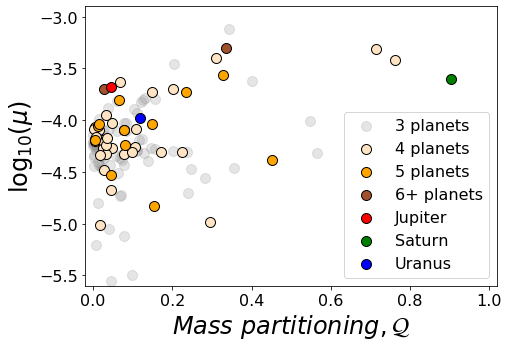

In [12]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Q vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(Q[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(Q[N==4], logmu[N==4], c='bisque', edgecolor='k', s=100, label='4 planets')
ax1.scatter(Q[N==5], logmu[N==5], c='orange', edgecolor='k', s=100, label='5 planets')
ax1.scatter(Q[N>=6], logmu[N>=6], c='sienna', edgecolor='k', s=100, label='6+ planets')
ax1.scatter(archinfo.Q([0.015, 0.008, 0.025, 0.018]), np.log10(archinfo.mu([0.015, 0.008, 0.025, 0.018], 9.542e-4)), c='red', edgecolor='k', s=100, label='Jupiter')
ax1.scatter(archinfo.Q([6.3e-6, 1.8e-5, 1.03e-4, 1.834e-4, 3.9e-4, 0.0225, 3.02e-4]), np.log10(archinfo.mu([6.3e-6, 1.8e-5, 1.03e-4, 1.834e-4, 3.9e-4, 0.0225, 3.02e-4], 2.857e-4)), c='green', edgecolor='k', s=100, label='Saturn')
ax1.scatter(archinfo.Q([5.69e-4, 5.15e-4, 2.09e-4, 2.13e-4, 1.07e-5]), np.log10(archinfo.mu([5.69e-4, 5.15e-4, 2.09e-4, 2.13e-4, 1.07e-5], 4.365e-5)), c='blue', edgecolor='k', s=100, label='Uranus')
ax1.set_xlim(-0.02,1.02)
ax1.set_xlabel(r'$Mass\ partitioning, \mathcal{Q}$',fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$', fontsize=24)
ax1.legend(loc='lower right', frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)

plt.savefig(MAINPATH + 'Figures/masspartitioning.pdf',bbox_inches='tight')
plt.show()

In [13]:
M3 = M[N==3]
M2 = M[N==2]
M4 = M[N>=4]

M2 = np.sort(np.squeeze(M2))
M3 = np.sort(np.squeeze(M3))
M4 = np.sort(np.squeeze(M4))


KS_M32 = np.array(stats.ks_2samp(M3,M2))
KS_M43 = np.array(stats.ks_2samp(M4,M3))

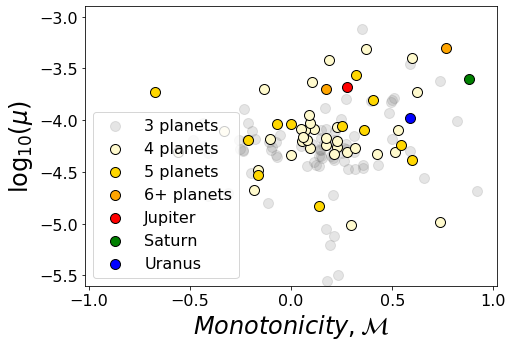

In [14]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# M vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(M[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(M[N==4], logmu[N==4], c='lemonchiffon', edgecolor='k', s=100, label='4 planets')
ax1.scatter(M[N==5], logmu[N==5], c='gold', edgecolor='k', s=100, label='5 planets')
ax1.scatter(M[N>=6], logmu[N>=6], c='orange', edgecolor='k', s=100, label='6+ planets')
ax1.scatter(archinfo.M([1.769137786, 3.551181, 7.15455296, 16.6890184], [0.015, 0.008, 0.025, 0.018]), np.log10(archinfo.mu([0.015, 0.008, 0.025, 0.018], 9.542e-4)), c='red', edgecolor='k', s=100, label='Jupiter')
ax1.scatter(archinfo.M([0.942, 1.370218, 1.887802, 2.736915, 4.518212, 15.945, 79.3215],[6.3e-6, 1.8e-5, 1.03e-4, 1.834e-4, 3.9e-4, 0.0225, 3.02e-4]), np.log10(archinfo.mu([6.3e-6, 1.8e-5, 1.03e-4, 1.834e-4, 3.9e-4, 0.0225, 3.02e-4], 2.857e-4)), c='green', edgecolor='k', s=100, label='Saturn')
ax1.scatter(archinfo.M([8.706234, 13.463234, 2.520, 4.144, 1.413479],[5.69e-4, 5.15e-4, 2.09e-4, 2.13e-4, 1.07e-5]), np.log10(archinfo.mu([5.69e-4, 5.15e-4, 2.09e-4, 2.13e-4, 1.07e-5], 4.365e-5)), c='blue', edgecolor='k', s=100, label='Uranus')
ax1.set_xlim(-1.02,1.02)
ax1.set_xlabel(r'$Monotonicity, \mathcal{M}$', fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower left',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


plt.savefig(MAINPATH + 'Figures/monotonicity.pdf',bbox_inches='tight')
plt.show()

# Results for $\mathcal{S}$ and $\mathcal{C}$ 

In [15]:
# 4- and 5-planet systems with second-to-last planet removed
P4 = 2**np.arange(4)
P5 = 2**np.arange(5)

P43 = P4[[0,1,3]]
P54 = P5[[0,1,2,4]]
P53 = P5[[0,1,4]]

pstar43 = np.log(P43[1:]/P43[:-1])/np.log(P43.max()/P43.min())
pstar54 = np.log(P54[1:]/P54[:-1])/np.log(P54.max()/P54.min())
pstar53 = np.log(P53[1:]/P53[:-1])/np.log(P53.max()/P53.min())


C43 = LMC.C(pstar43)
C54 = LMC.C(pstar54)
C53 = LMC.C(pstar53)

print(C43, C54, C53)

[0.33363585] [0.20406347] [0.66319675]


In [16]:
# compare C for 3 and 4+ planet systems
C3 = C[N==3]
C4 = C[N>=4]

C3 = np.sort(np.squeeze(C3))
C4 = np.sort(np.squeeze(C4))

KS_C = np.array(stats.ks_2samp(C3,C4))
AD_C = np.array(stats.anderson_ksamp([C3,C4]))

In [17]:
S2 = S[N==2]
S3 = S[N==3]
S4 = S[N>=4]

S2 = np.sort(S2)
S3 = np.sort(S3)
S4 = np.sort(S4)

KS_S32 = np.array(stats.ks_2samp(S3,S2))
KS_S43 = np.array(stats.ks_2samp(S4,S3))

AD_S32 = np.array(stats.anderson_ksamp([S3,S2]))
AD_S43 = np.array(stats.anderson_ksamp([S4,S3]))

C:\Users\djhoo\Miniconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: p-value floored: true value smaller than 0.001
  del sys.path[0]


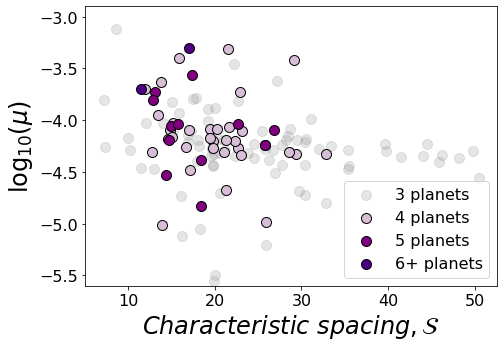

In [18]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# S vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(S[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(S[N==4], logmu[N==4], c='thistle', edgecolor='k', s=100, label='4 planets')
ax1.scatter(S[N==5], logmu[N==5], c='purple', edgecolor='k', s=100, label='5 planets')
ax1.scatter(S[N>=6], logmu[N>=6], c='indigo', edgecolor='k', s=100, label='6+ planets')
#ax1.scatter(archinfo.S(np.array([1.769137786, 3.551181, 7.15455296, 16.6890184]),np.array([0.015, 0.008, 0.025, 0.018]),9.542e-4),np.log10(archinfo.mu([0.015, 0.008, 0.025, 0.018],9.542e-4)),c='red', edgecolor='k', s=100, label='Jupiter')
#ax1.scatter(archinfo.S(np.array([0.942, 1.370218, 1.887802, 2.736915, 4.518212, 15.945, 79.3215]), np.array([6.3e-6, 1.8e-5, 1.03e-4, 1.834e-4, 3.9e-4, 0.0225, 3.02e-4]), 2.857e-4), np.log10(archinfo.mu([6.3e-6, 1.8e-5, 1.03e-4, 1.834e-4, 3.9e-4, 0.0225, 3.02e-4],  2.857e-4)), c='green', edgecolor='k', s=100, label='Saturn')
#ax1.scatter(archinfo.S(np.array([8.706234, 13.463234, 2.520, 4.144, 1.413479]), np.array([5.69e-4, 5.15e-4, 2.09e-4, 2.13e-4, 1.07e-5]), 4.365e-5), np.log10(archinfo.mu([5.69e-4, 5.15e-4, 2.09e-4, 2.13e-4, 1.07e-5], 4.365e-5)), c='blue', edgecolor='k', s=100, label='Uranus')
#ax1.set_xlim(-4000,15000)
ax1.set_xlabel(r'$Characteristic\ spacing, \mathcal{S}$', fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower right',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)

plt.savefig(MAINPATH + 'Figures/characteristicspacing.pdf',bbox_inches='tight')
plt.show()

In [36]:
archinfo.characteristic_spacing?

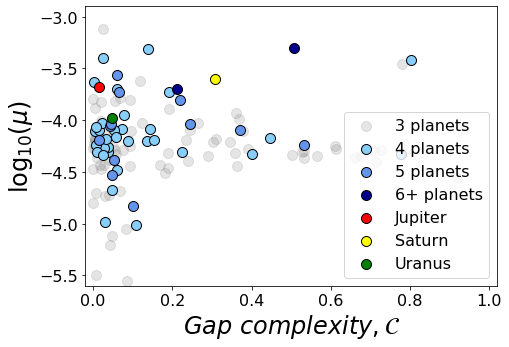

In [19]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# C vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(C[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(C[N==4], logmu[N==4], c='lightskyblue', edgecolor='k', s=100, label='4 planets')
ax1.scatter(C[N==5], logmu[N==5], c='cornflowerblue', edgecolor='k', s=100, label='5 planets')
ax1.scatter(C[N>=6], logmu[N>=6], c='darkblue', edgecolor='k', s=100, label='6+ planets')
ax1.scatter(archinfo.C([1.769137786, 3.551181, 7.15455296, 16.6890184]), np.log10(archinfo.mu([0.015, 0.008, 0.025, 0.018], 9.542e-4)), c='red', edgecolor='k', s=100, label='Jupiter')
ax1.scatter(archinfo.C([0.942, 1.370218, 1.887802, 2.736915, 4.518212, 15.945, 79.3215]), np.log10(archinfo.mu([6.3e-6, 1.8e-5, 1.03e-4, 1.834e-4, 3.9e-4, 0.0225, 3.02e-4], 2.857e-4)), c='yellow', edgecolor='k', s=100, label='Saturn')
ax1.scatter(archinfo.C([8.706234, 13.463234, 2.520, 4.144, 1.413479]), np.log10(archinfo.mu([5.69e-4, 5.15e-4, 2.09e-4, 2.13e-4, 1.07e-5], 4.365e-5)), c='green', edgecolor='k', s=100, label='Uranus')
ax1.set_xlim(-0.02,1.02)
ax1.set_xlabel(r'$Gap\ complexity, \mathcal{C}$', fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower right',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


plt.savefig(MAINPATH + 'Figures/gap_complexity.pdf',bbox_inches='tight')
plt.show()

# Results for $\mathcal{f}$

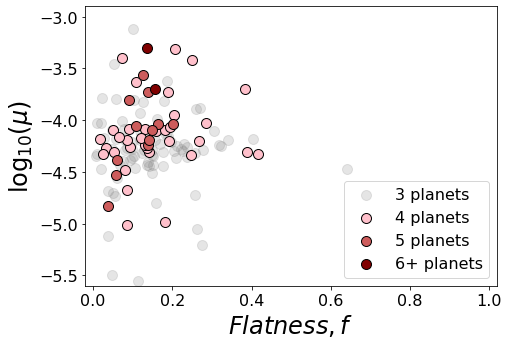

In [20]:
plt.figure(figsize=(10,7))
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# f vs mu scatter plot
ax1 = plt.subplot2grid((4,4),(1,0),colspan=3,rowspan=3)
ax1.scatter(f[N==3], logmu[N==3], c='grey',   alpha=0.2,     s=100, label='3 planets')
ax1.scatter(f[N==4], logmu[N==4], c='pink', edgecolor='k', s=100, label='4 planets')
ax1.scatter(f[N==5], logmu[N==5], c='indianred', edgecolor='k', s=100, label='5 planets')
ax1.scatter(f[N>=6], logmu[N>=6], c='maroon', edgecolor='k', s=100, label='6+ planets')
ax1.set_xlim(-0.02,1.02)
ax1.set_xlabel(r'$Flatness, f$', fontsize=24)
ax1.set_ylim(-5.6,-2.9)
ax1.set_ylabel(r'$\log_{10}(\mu)$',fontsize=24)
ax1.legend(loc='lower right',frameon=True, fontsize=16)
ax1.tick_params(labelsize=16)


plt.savefig(MAINPATH + 'Figures/flatness.pdf',bbox_inches='tight')
plt.show()